In [1]:
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import flopy
import shapefile as sf
import pandas as pd
import shapely.geometry as geom
import mplleaflet
import warnings

from IPython.display import clear_output, display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from flopy.utils.gridgen import Gridgen
from flopy.discretization.structuredgrid import StructuredGrid
from scipy.interpolate import griddata
from flopy.utils.triangle import Triangle as Triangle
from collections import OrderedDict
from shapely.geometry import *
from shapely.strtree import STRtree
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
warnings.filterwarnings("ignore")

flopy is installed in G:\hydro\anaconda3\envs\ropen\lib\site-packages\flopy


In [2]:
def intersect(mglist, shp, shptype="POLYGON"):
    intersect_dict = {}
    
    s = STRtree(mglist)
    
    result = s.query(shp)
    
    isectshp = []
    cellids = []
    vertices = []
    areas = []
    lengths = []
    
    for i, r in enumerate(result):
        intersect = shp.intersection(r)

        if shptype == "POLYGON":
            if intersect.area > 0.0:
                cellids.append(mglist.index(r))
                isectshp.append(intersect)
                areas.append(intersect.area)
                vertices.append(intersect.__geo_interface__["coordinates"])
        elif shptype == "POLYLINE":
            try:
                isect_iter = iter(intersect)
            except TypeError:
                isect_iter = [intersect]
            
            for isect in isect_iter:
                if isect.length > 0.0:
                    cellids.append(mglist.index(r))
                    isectshp.append(isect)
                    lengths.append(isect.length)
                    vertices.append(isect.__geo_interface__["coordinates"])
        else:
            raise NotImplementedError("shptype '{}' is not supported!".format(shptype))
    
    intersect_dict["intersect"] = isectshp
    intersect_dict["cellids"] = cellids
    intersect_dict["vertices"] = vertices
    if shptype == "POLYGON":
        intersect_dict["areas"] = areas
    elif shptype == "POLYLINE":
        intersect_dict["lengths"] = lengths
    
    return intersect_dict

In [3]:
modelname = 'Fensholt'

workspace = os.path.join('.',modelname)
figpth = os.path.join(workspace, 'figures21')

if not os.path.exists(workspace):
    os.makedirs(workspace)

if not os.path.exists(figpth):
    os.makedirs(figpth)

In [4]:
Shortdescription = 'Model consists of 2 layers with the bottom layer being a clay layer and the top being a till. The model has drains everywhere all available Db data from 2012-2017 as hard recharge data for the model in rch_spd. All set to m/s. Conductivity is changed for the next models to more clayey. The drains are set to hard drainage data aswell, to compare drainage measured and modelled. Some measurements in HYD was removed (A B C), and plots were fixed'
f = open(os.path.join(figpth, 'Short_Description'),"w")
f.write(str(Shortdescription))
f.close()

In [5]:
mf = flopy.modflow.Modflow(modelname, exe_name="Exe/MODFLOW-NWT_64.exe", version="mfnwt",model_ws=workspace)

#Definition of MODFLOW NWT Solver
nwt = flopy.modflow.ModflowNwt(mf ,maxiterout=2000,linmeth=2,headtol=0.01)

In [6]:
#import data observations
poo = pd.read_csv('Shpfiles/f_piezo_original.csv')
data_df = pd.read_csv('Shpfiles/Fensholt_D3_daily_2.csv')

In [7]:
data_df['Dato'] = pd.to_datetime(data_df['Dato'])
data_df.tail(15)

,Dato,Qest (L/s),Qest (mm/d),Qest (m/d),Tmean,Pkorr (mm),Pkorr (m),Epot (mm),Epot (m),(Db),Recharge(mm),Recharge(m),Unnamed: 12,Date,Qest (mm/d).1,Recharge (mm),Discrepancy
1853,2017-05-17,0.00,0.000,0.000000,15.4,0.230,0.00023,2.0,0.0020,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1854,2017-05-18,0.00,0.000,0.000000,16.6,0.000,0.00000,3.5,0.0035,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1855,2017-05-19,0.36,0.114,0.000114,14.4,0.000,0.00000,3.6,0.0036,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1856,2017-05-20,0.49,0.155,0.000155,12.6,0.000,0.00000,2.3,0.0023,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1857,2017-05-21,0.30,0.095,0.000095,12.9,0.000,0.00000,3.9,0.0039,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1858,2017-05-22,0.00,0.000,0.000000,12.0,0.000,0.00000,4.0,0.0040,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1859,2017-05-23,0.30,0.095,0.000095,12.9,17.250,0.01725,3.3,0.0033,0.0,13.95,0.01395,NaN,NaN,NaN,NaN,NaN
1860,2017-05-24,0.00,0.000,0.000000,12.9,0.000,0.00000,4.1,0.0041,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1861,2017-05-25,0.00,0.000,0.000000,14.5,0.000,0.00000,4.8,0.0048,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN
1862,2017-05-26,0.05,0.016,0.000016,16.6,0.000,0.00000,5.0,0.0050,0.0,0.00,0.00000,NaN,NaN,NaN,NaN,NaN


In [8]:
data_df.to_csv(os.path.join(workspace,'F_all_data'+'.csv'))

In [9]:
#import shapefiles to construct model discretization
modellimshp = sf.Reader('Shpfiles/basin_rrf_2020_05_20.shp')
modelpiezoshp = sf.Reader('Shpfiles/f_all_piezo.shp')
modeldrain = sf.Reader('Shpfiles/f_all_drain.shp')

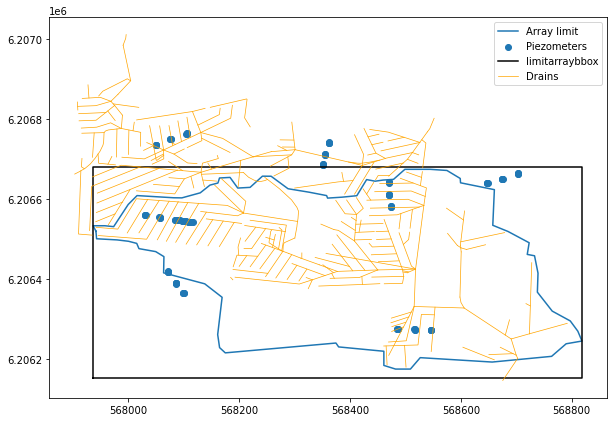

In [10]:
limitarray = np.array(modellimshp.shapeRecords()[0].shape.points)
piezoarray = np.array([point.shape.points[0] for point in modelpiezoshp.shapeRecords()])
drain_coords = []
bbox = modellimshp.bbox

for i in np.arange(len(modeldrain.shapeRecords())):
    drain_coords = drain_coords + [modeldrain.shapeRecords()[i].shape.points[:]]    
    
drain_mls = MultiLineString(drain_coords)
    
fig = plt.figure(figsize=(10,7))
limitlines, = plt.plot(limitarray[:,0],limitarray[:,1])
limitbbox, = plt.plot([bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]], [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]], color='black')
piezoscatter = plt.scatter(piezoarray[:,0],piezoarray[:,1])
for ig in drain_mls.geoms:
    drainlines, = plt.plot(ig.xy[0], ig.xy[1], color='orange', linewidth=0.7)

    
plt.show;
plt.legend([limitlines,piezoscatter,limitbbox,drainlines],['Array limit','Piezometers','limitarraybbox','Drains'],loc='upper right');

In [11]:
fig = plt.figure(figsize=(20,9))
plt.plot([bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]], [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]], color='black')
plt.plot(limitarray[:,0],limitarray[:,1])
plt.show

crs = {'init' : 'epsg:25832'}
mplleaflet.display(fig,crs=crs)

In [12]:
bbox

[567936.4007270695, 6206153.158283861, 568818.390673467, 6206680.466120016]

In [13]:
CellSize = 25 #length of each cell so its 10 utmx x 10 utmy
cbc_unit = 53

In [14]:
def arrayGenerator(BboxRef, CellSize):

    cellArrayCol = np.array([])
    cellArrayRow = np.array([])

    while cellArrayCol.sum() + BboxRef[0] < BboxRef[2]:
        cellArrayCol = np.append(cellArrayCol,[CellSize])
    
    while cellArrayRow.sum() + BboxRef[1] < BboxRef[3]:
        cellArrayRow = np.append(cellArrayRow,[CellSize])

    return cellArrayCol, cellArrayRow

In [15]:
#start discretization of model
delR, delC = arrayGenerator(bbox, CellSize)

nrows = delC.shape[0]
ncols = delR.shape[0]
nlay = 2
mtop = 1
botm = [0, -1]

nper =  len(data_df['Dato']) #5 years stres period
perlen = np.ones(nper)
perlen[0] = 1 #steady state
perlen[1:] = 1  #1 day

nstp = np.ones(nper) #number og time steps must be equal to nper.
nstp[0] = 1 #steady state
nstp[1:] = 1 #length of each timestep, 10 timesteps pr day

tsmult = 1
itmuni = 4 #days
lenuni = 2 #meters

periodType = np.zeros(nper, dtype=bool)
periodType[0] = True

dis = flopy.modflow.ModflowDis(mf, nlay=nlay,
                               nrow=nrows,ncol=ncols,
                               delr=delR,delc=delC,
                               top=mtop,botm=botm,
                               itmuni=itmuni,lenuni=lenuni,nper=nper,
                               perlen=perlen,nstp=nstp,
                               tsmult=tsmult,steady=periodType,
                               xul=bbox[0], yul= bbox[3], start_datetime = '2012-04-20 00:00:01.000002')

print('nrows = {}'.format(nrows), 'ncols = {}'.format(ncols),
      'nlay = {}'.format(nlay), 'nper ={}'.format(nper))

nrows = 22 ncols = 36 nlay = 2 nper =1868


In [16]:
mf.dis.structuredgrid = StructuredGrid(delr=delR,delc=delC,epsg=25832)
mf.dis.structuredgrid.epsg

25832

In [18]:
mf.modelgrid.set_coord_info(xoff=bbox[0], yoff=bbox[3]-delC.sum(), angrot=0,epsg=25832)

In [19]:
fens_dem = flopy.utils.Raster.load("Shpfiles/Fensholt_DEM_Drænopland.TIF")

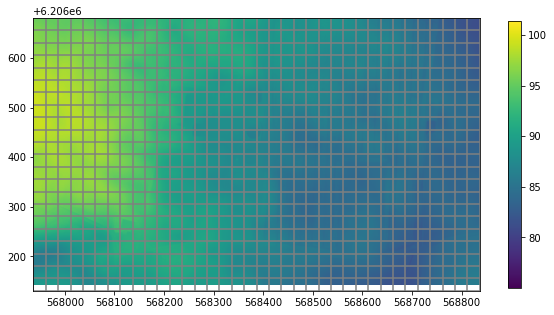

In [20]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = fens_dem.plot(ax=ax)
plt.colorbar(ax.images[0], shrink=0.7);
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid)
pmv.plot_grid(ax=ax)

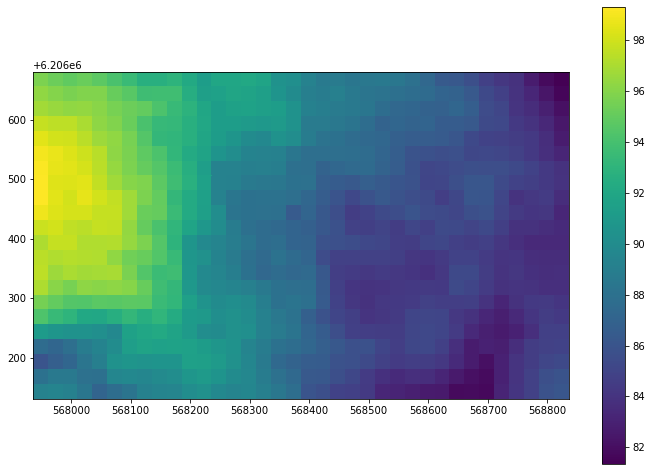

In [21]:
t0 = time.time()
dem_data = fens_dem.resample_to_grid(mf.modelgrid.xcellcenters,
                                mf.modelgrid.ycellcenters,
                                band=fens_dem.bands[0],
                                method="nearest")
resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
ax = pmv.plot_array(dem_data)
plt.colorbar(ax, shrink=0.7);

In [23]:
mtop = dem_data
mtop[:5,:5]

array([[95.75934 , 95.252205, 94.929   , 95.21796 , 94.79595 ],
       [96.3329  , 95.964874, 95.69012 , 95.88255 , 95.87695 ],
       [96.825005, 96.51455 , 96.35012 , 96.41589 , 96.07792 ],
       [97.72734 , 97.52861 , 97.5449  , 97.02414 , 96.25157 ],
       [98.50079 , 98.05424 , 98.03549 , 97.45997 , 96.69422 ]],
      dtype=float32)

In [24]:
def bottom_generator(filepath, method):
    
    layer = pd.read_csv(filepath,sep=';')
    points = layer[['X','Y']].values
    values = layer[['Z']].values
    grid_x = mf.modelgrid.xcellcenters
    grid_y = mf.modelgrid.ycellcenters
    Bottom_grid = griddata(points, values, (grid_x, grid_y), method)
    Bottom_grid = Bottom_grid.reshape((nrows,ncols))

    return Bottom_grid

In [25]:
bottom_sandy_till = bottom_generator('Fensholt_grids/Bottom_sandy_till.CSV', 'nearest')
bottom_sandy_till[bottom_sandy_till>=mtop] = mtop[bottom_sandy_till>=mtop]-0.1
#diff_test = mtop-bottom_sandy_till
#diff_test

In [26]:
#Setting up layers for the modflow model
bottom_clayey_till = bottom_generator('Fensholt_grids/Bottom_clayey_till.CSV', 'nearest')
bottom_clayey_till[bottom_clayey_till>=bottom_sandy_till] = bottom_sandy_till[bottom_clayey_till>=bottom_sandy_till]-0.1

bottom_sand = bottom_generator('Fensholt_grids/Bottom_sand.CSV', 'nearest')
bottom_sand[bottom_sand>=bottom_clayey_till] = bottom_clayey_till[bottom_sand>=bottom_clayey_till]-0.1


bottom_basement = bottom_generator('Fensholt_grids/Bottom_clay.CSV', 'nearest')
bottom_basement[bottom_basement>=bottom_sand] = bottom_sand[bottom_basement>=bottom_sand]-0.1

zbot = np.zeros((nlay,nrows,ncols))

zbot[0,:,:] = bottom_sandy_till
zbot[1,:,:] = bottom_clayey_till
#zbot[2,:,:] = bottom_sand
#zbot[3,:,:] = bottom_basement

#Asign layer bottom elevations
mf.dis.botm = zbot

In [27]:
mf.dis.top  = mtop

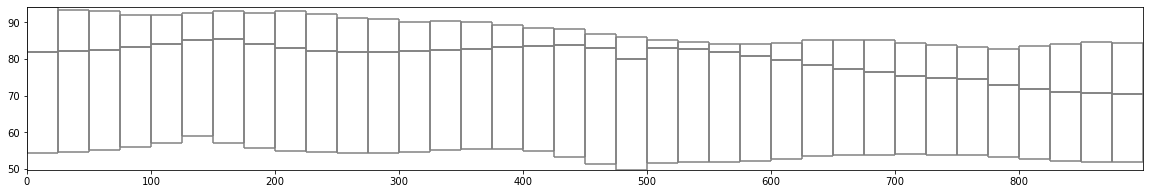

In [28]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'row': 16})
linecollection = modelxsect.plot_grid()

In [29]:
#m/d
k_values = {'hk0':[2.0e-4],
           'hk1':[8.64e-5]}

f = open(os.path.join(figpth, 'k_values'),"w")
f.write(str(k_values))
f.close()

In [30]:
grid_cells = []

nx = ncols
ny = nrows

x0, y0 = bbox[0], bbox[1]
dx, dy = CellSize, CellSize

for i in range(ny):
    for j in range(nx):
        x = x0+j*dx
        y = y0+i*dy
        xy = [[x, y], [x+dx, y], [x+dx, y+dy], [x, y+dy], [x, y]]
        grid_cells.append(Polygon(xy))

In [31]:
poly_intersect = Polygon(limitarray)

In [32]:
result1 = intersect(grid_cells, poly_intersect, shptype="POLYGON")

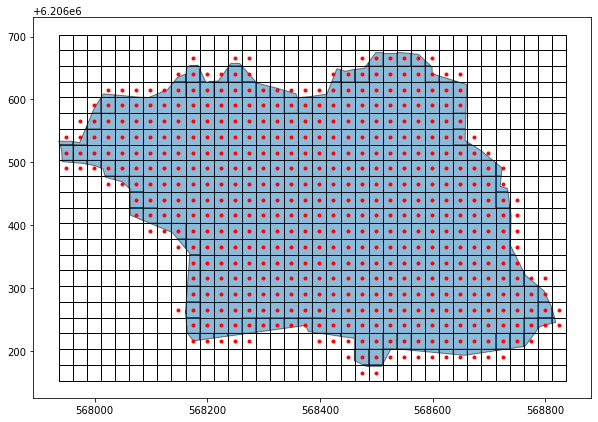

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for g in grid_cells:
    pp = PolygonPatch(g, edgecolor="k", alpha=1.0, facecolor="none")
    ax.add_patch(pp)

for i, ishp in enumerate(result1["intersect"]):
    ppi = PolygonPatch(ishp, facecolor="C{}".format(10), alpha=0.5)
    ax.add_patch(ppi)
        
for cid in result1["cellids"]:
    c = grid_cells[cid].centroid
    ax.plot(c.x, c.y, "r.")

plt.show()

In [34]:
ibound = np.zeros([nlay,nrows,ncols])

for k in result1["cellids"]:
    for i in range(nrows):
        a_range = np.arange((ncols*i), (ncols*(i+1)))
        a_list = list(a_range)
        try:
            index = a_list.index(k)
            ibound[:,i,index] = 1
        except ValueError:
            continue

In [35]:
ibound = ibound[:,::-1,:]
strt = mtop

In [36]:
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [37]:
hkarray = np.zeros((nlay,nrows,ncols))

for j in np.arange(nlay):
    hkarray[j,:,:] = k_values['hk{}'.format(j)]

hkarray[ibound == 0] = 0

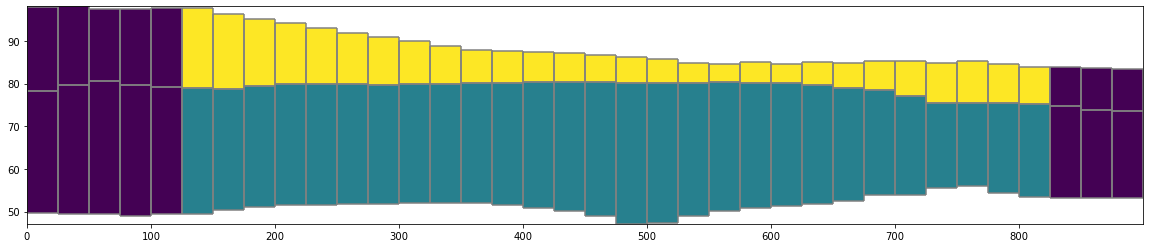

In [38]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 10})
linecollection = modelxsect.plot_grid()
modelxsect.plot_array(hkarray)
fig.savefig(os.path.join(figpth, 'CrossSection_Row10'),transparent=False, bbox_inches='tight', pad_inches=0.05)

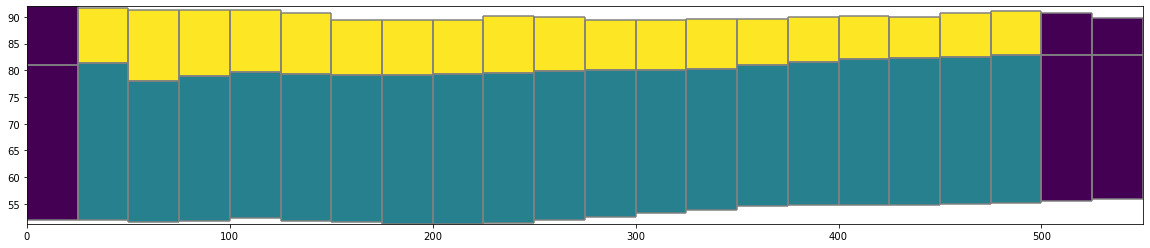

In [39]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Column': 12})
linecollection = modelxsect.plot_grid()
modelxsect.plot_array(hkarray)
fig.savefig(os.path.join(figpth, 'CrossSection_Column12'),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [41]:
laytyp = [1,0]
upw = flopy.modflow.ModflowUpw(mf, ipakcb = cbc_unit, laytyp = laytyp, hk = hkarray, vka =hkarray,
                              ss=1e-05, sy=0.15)

In [43]:
rch = data_df['(Db)']/1000 #rch is in m/d
rch_spd = {}

rch = np.nan_to_num(rch)

rch_array = np.zeros([nrows,ncols])

for i in range(nper):
    rech = rch_array+rch[i]
    rch_spd[i] = rech

In [44]:
for i in range(len(rch_spd)):
    rch_spd[i][ibound[0,:,:] == 0] = 0

rch = flopy.modflow.ModflowRch(mf, ipakcb = cbc_unit, nrchop=3, rech=rch_spd, unitnumber=18)

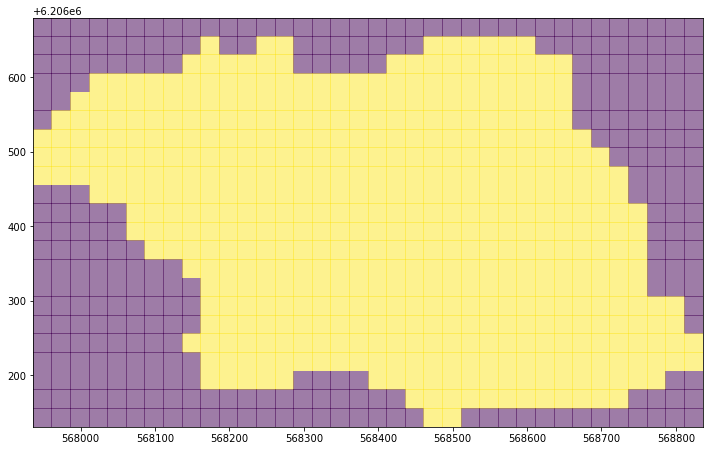

In [45]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=mf)
quadmesh = modelmap.plot_array(mf.rch.rech.array[8,0,:,:], alpha=0.3)

In [46]:
drnbound = ibound[0,:,:]

steady_state_drn = 0.1 #100 L in m^3/s
drnRate = data_df['Qest (m/d)'] #to get drn in m^3/s /number of cells drained

drnRate = np.nan_to_num(drnRate)
#drnRate = drnRate[::-1]

#drnRate = np.append(rchRate, steady_state_drn)
#drnRate = drnRate[::-1]

lrcec = {}
array = []
arrays = []

for n in range(nper):
    for i in range(len(drnbound[:,0])):
        for j in range(len(drnbound[0,:])):
            if drnbound[i,j]==1:
                array = [1,i,j,(mtop[i,j]-1.5),1]
                arrays.append(array)
                array = []
            else:
                continue

lrcec[0] = arrays

In [47]:
drn = flopy.modflow.ModflowDrn(mf, ipakcb = cbc_unit, stress_period_data = lrcec)

In [48]:
#HoB package


In [49]:
#HyD package
poo = pd.read_csv('Shpfiles/f_piezo.csv')
wel_df = poo[['Piezo','East','North']].copy()
wel_df['PCKG'] = 'BAS'
wel_df['ARR'] = 'HD'
wel_df['INTYP'] = 'I'
for i in ['North']:
    wel_df[i] = (wel_df[i]-bbox[1]).astype(int) # adjust to python syntax
for i in ['East']:
    wel_df[i] = (wel_df[i]-bbox[0]).astype(int) # adjust to python syntax
layer = np.ones(len(wel_df['Piezo'])).astype(int)
wel_df['Layer'] = layer
cols = ['PCKG','ARR','INTYP','Layer','East','North','Piezo']
hyd_df = wel_df.copy()
hyd_rec = hyd_df[cols].values
hyd = flopy.modflow.ModflowHyd(mf, nhyd=hyd_rec.shape[0], obsdata=hyd_rec, unitnumber=71)

In [72]:
mf.remove_package('OC')

In [73]:
oc_spd = {(0, 0): ['save head', 'save budget']}

for i in range(mf.dis.nstp.shape[0]):
    oc_spd[(i,mf.dis.nstp.array[-2])] = ['save head', 'save budget']


In [74]:
mf.dis.nstp.shape[0]

1868

In [91]:
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, save_every=True)

In [92]:
mf.write_input()
mf.run_model()

FloPy is using the following  executable to run the model: Exe/MODFLOW-NWT_64.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: Fensholt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/10  8:34:06

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Groundwater-Flow Eqn.
 Solv

(True, [])

In [93]:
mfheads = flopy.utils.HeadFile('Fensholt/Fensholt.hds', model=mf)
#mfheads.times

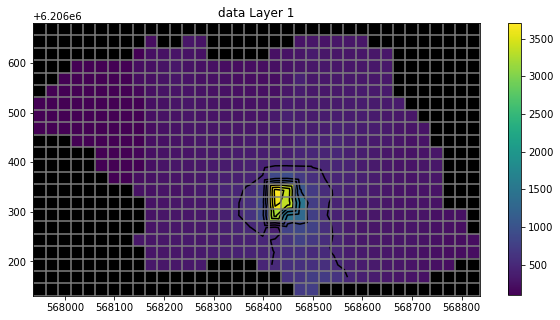

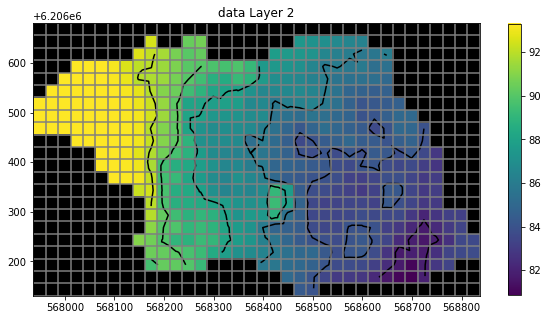

In [95]:
mfheads.plot(totim=1868, contour=True, grid=True, colorbar=True, figsize=(10,10));

In [79]:
mfheads.

SyntaxError: invalid syntax (<ipython-input-79-d327b6549543>, line 1)

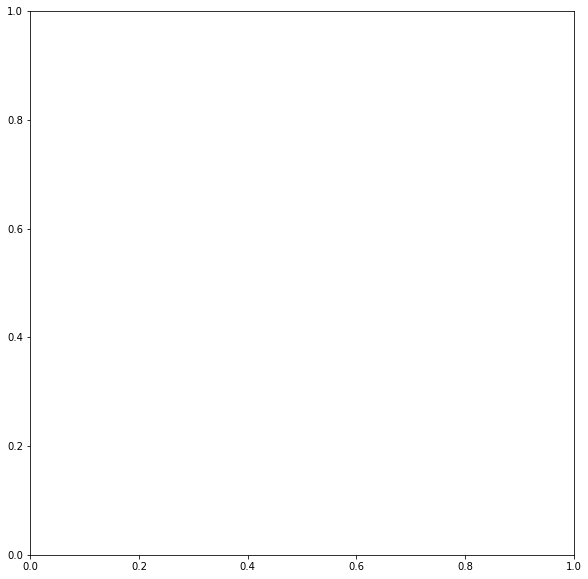

In [80]:
f = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
for i, t in enumerate(mfheads.times[0:-1:10]):
    ax.set_title("totim:{0}".format(t))
    mfheads.plot(totim=t, mflay=1, contour=True,
           grid=True, figsize=(10,10),
            vmin=0, vmax=20, axes=[ax])
    time.sleep(0.1)
    clear_output(True)
    display(f)
    ax.cla()

In [81]:
h = mfheads.get_data()

OSError: datafile error: file is empty: .\Fensholt\Fensholt.cbc

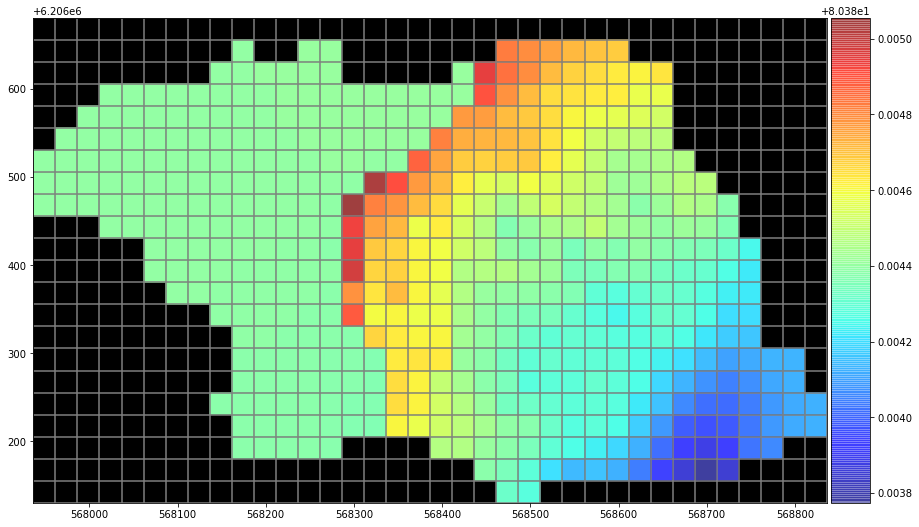

In [96]:
# Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
quadmesh = modelmap.plot_grid()
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_bc('drn')
quadmesh = modelmap.plot_array(h, masked_values=[-999.99], alpha=0.5,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)

cbb = flopy.utils.CellBudgetFile(os.path.join(workspace, modelname+'.cbc'))
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]
quiver = modelmap.plot_discharge(frf, fff, head = h)

fig.savefig(os.path.join(figpth, 'mapview_heads_L0'),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [87]:
kstpkper = (0,0)

for i in range(mf.dis.nstp.shape[0]):
    kstpkper = kstpkper + (i,mf.dis.nstp.array[-2])

In [99]:
cbb_list=cbb.get_indices()

In [100]:
cbb_list

In [98]:
drn_cbb = cbb.get_data(kstpkper=kstpkper, text='DRAINs')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [90]:
drn_cbb

[rec.array([],
           dtype=[('node', '<i4'), ('q', '<f4')]),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 

In [ ]:
data = cbf.get_data(kstpkper=(0,0))
plt.bar(data['index'], data['value'])
plt.xticks(data['index'], data['name'], rotation=45, size=6)
plt.show()

In [ ]:
mfl = flopy.utils.MfListBudget(os.path.join(workspace, modelname+'.list'))
incrementaldf, cumulativedf = mfl.get_dataframes()
cum = cumulativedf.T
cum.to_csv(os.path.join(figpth, 'out_mass_balance_'+'.csv'),index_label='Component')

fig,ax = plt.subplots(figsize=(20,8))
cum.plot(ax=ax, kind='bar', legend=False)
ax.grid(ls='--')
fig.savefig(os.path.join(figpth, 'out_mass_balance_'+'.png'),
            transparent=False, bbox_inches='tight', pad_inches=0.05)

In [ ]:
cumulativedf.set_index(data_df['Dato']).head(15)

In [ ]:
fig, ax3 = plt.subplots(1, 1, figsize=(17,15))
cumulativedf.iloc[:,7].plot(ax=ax3)
drains = data_df['Qest (L/s)']/1000
cumsum_drn = drains.cumsum()
cumsum_drn.plot(ax=ax3)
ax3.grid()
ax3.set_ylabel('Absolute Pressure (kPa)')

In [ ]:
cumsum_drn.head()

In [ ]:
inc = incrementaldf.T
inc.to_csv(os.path.join(figpth, 'out_mass_balance_full_'+'.csv'),index_label='Component')

fig,ax = plt.subplots(figsize=(20,8))
inc.plot(ax=ax, kind='bar', legend=False)
ax.grid(ls='--')
ax.set_ylim(0, 0.5e7)
fig.savefig(os.path.join(figpth, 'out_mass_balance_full_'+'.png'),
            transparent=False, bbox_inches='tight', pad_inches=0.05)

In [ ]:
h = head
h[h == -999.99] = np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
x = mf.dis.sr.xcentergrid[0]
ax.plot(x,h[0,10,:], label='Head')
ax.plot(x,mtop[10,:], label='Terrain')
ax.set_xlim(x.min(),x.max())
ax.set_ylim(80,100)
ax.set_xlabel("x(m)")
ax.set_ylabel("head(m)")
ax.legend()
plt.show()
fig.savefig(os.path.join(figpth, 'Head'+'.png'),
            transparent=False, bbox_inches='tight', pad_inches=0.05)

In [ ]:
hydbinfn = os.path.join(workspace, modelname + '.hyd.bin')
hydpoo = flopy.utils.HydmodObs(hydbinfn).get_dataframe(timeunit='S')
hydpoo.drop('totim', axis=1, inplace=True)
hydpoo = hydpoo.iloc[1:]
sim_values = hydpoo.values.tolist()[0]
sim_index = hydpoo.columns.tolist()
sim_index_short = [i[6:] for i in sim_index]
del hydpoo
# obs
df = poo
# combined
df['sim'] = sim_values
df['res'] = df['mean_water_level (m)'] - df['sim']
out = df[df.sim != -999]
df.to_csv(os.path.join(workspace, modelname + 'out_heads.dat'), float_format='%.4e')
HeadLocdf = df

In [ ]:
HeadLocdf.head(10)

In [ ]:
figzoom = 1
figheight = 10*figzoom
figwidth = figheight*(18/12)
fig,ax = plt.subplots(figsize=(figheight,figwidth))
modelmap = flopy.plot.PlotMapView(model=mf, layer=0) # create an instance of the ModelMap class
quadmesh = modelmap.plot_ibound()
obsc = ax.scatter((HeadLocdf['East']),
                  (HeadLocdf['North']),
                  c = HeadLocdf['res'],
                  s = 80, edgecolor='black',
                  cmap='bwr', vmax=10, vmin=-10,
                  zorder=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(obsc, cax=cax, shrink=0.5)
ax.set_title('Residual (obs - sim) in m',fontsize=16)
linecollection = modelmap.plot_grid()
fig.savefig(os.path.join(figpth,'mapview_head_residuals'),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [ ]:
obs = HeadLocdf['mean_water_level (m)'][HeadLocdf['sim']>-990]
sim = HeadLocdf['sim'][HeadLocdf['sim']>-990]
res = HeadLocdf['res'][HeadLocdf['sim']>-990]
data = pd.DataFrame({'obs':obs,'sim':sim})
#==============
# Set-up figure
#==============
fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(obs,sim)
mn, mx = 50,130
ax.set_xlim(mn, mx)
ax.set_ylim(mn, mx)
ax.plot(np.asarray([mn, mx]), np.asarray([mn, mx * 0.8]), color='red', lw=1, ls=':', label='+/- 20% misfit')
ax.plot(np.asarray([mn, mx * 0.8]), np.asarray([mn, mx]), color='red', lw=1, ls=':')
ax.plot(np.asarray([mn, mx]), np.asarray([mn, mx * 0.5]), color='red', lw=1, ls='--', label='+/- 50% misfit')
ax.plot(np.asarray([mn, mx * 0.5]), np.asarray([mn, mx]), color='red', lw=1, ls='--')
#
step = 10.0
ax.set_xticks(np.arange(mn, mx + step, step))
ax.set_yticks(np.arange(mn, mx + step, step))
#
ax.grid()
ax.set_xlabel('observed head in m')
ax.set_ylabel('simulated head in m')
ax.legend(loc=4)
ax.grid(ls='--')
ax.set_title('Observed vs Simulated')
#================
# Annotate figure
#================
def calc_ME(data):
    """calculate mean error"""
    ME = (data['obs'] - data['sim']).mean()
    return np.round(ME, 2)
def calc_MAE(data):
    """calculate absolute mean error"""
    MAE = (data['obs'] - data['sim']).abs().mean()
    return np.round(MAE, 2)
def calc_RMSE(data):
    """Compute root-mean-square-error"""
    RMSE = np.sqrt(((data['obs'] - data['sim'])**2).mean())
    return np.round(RMSE, 2)
ax.annotate('ME: {0:.2f}\nMAE: {1:.2f}\nRMSE: {2:.2f}'.format(calc_ME(data),calc_MAE(data),calc_RMSE(data)),
            (0, 1), xytext=(10, -10),
            xycoords='axes fraction',
            textcoords='offset points',
            ha='left', va='top',
            fontsize=12,
            bbox=dict(alpha=1, fc='white'))
#============
# Save figure
#============
fig.savefig(os.path.join(figpth,'heads_obs_vs_sim_one2one'),transparent=False, bbox_inches='tight', pad_inches=0.05)